In [ ]:
Innodb Storage Engine 
======================================

-- it is the default storage engine from version 8.
-- supports ACID model , transactions ( rollback , commit ) and crash recovery.
-- supports foreign key constraints and row level locking.
-- supports full text search index and replication.

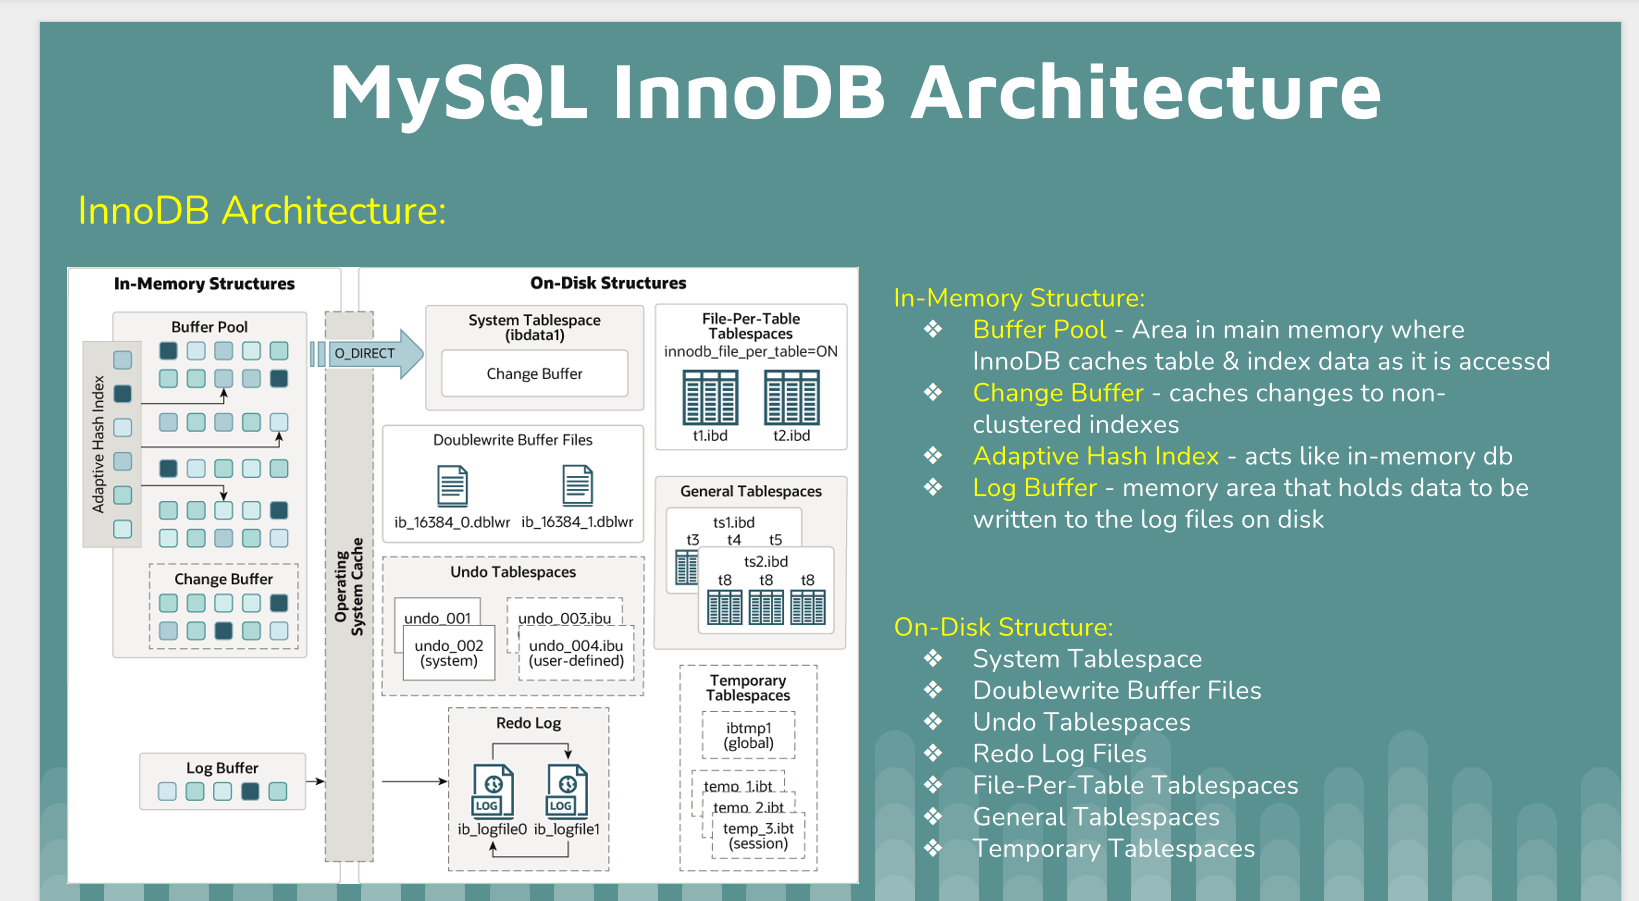

In [ ]:
buffer pool - part of the main memory which holds table and index data.
change buffer - part of the main memory which holds non clustered index data.
log buffer - part of the main memory which holds transactions/changes before transfering into redo logs.

In [ ]:
Innodb Buffer Pool 
===================================

-- part of the main memory where table and index data is cached.
-- controlled by system variable innodb_buffer_pool_size.

mysql> show engine innodb status \G
*************************** 1. row ***************************
  Type: InnoDB
  Name: 
Status: 

----------------------
BUFFER POOL AND MEMORY
----------------------
Total large memory allocated 0
Dictionary memory allocated 480465
Buffer pool size   8192
Free buffers       7096
Database pages     1091
Old database pages 422

mysql> show variables like '%innodb_buffer_pool%';
+-------------------------------------+----------------+
| Variable_name                       | Value          |
+-------------------------------------+----------------+
| innodb_buffer_pool_chunk_size       | 134217728      |
| innodb_buffer_pool_instances        | 1              |
| innodb_buffer_pool_size             | 134217728      |
+-------------------------------------+----------------+



Change innodb buffer pool size
==========================================

[root@mysqlserver ~]# cat /etc/mysql/my.cnf | grep includedir
!includedir /var/lib/mysql-files/
[root@mysqlserver ~]# 

[root@mysqlserver ~]# cd /var/lib/mysql-files/

[root@mysqlserver mysql-files]# vi innodb.cnf

[root@mysqlserver mysql-files]# cat innodb.cnf 
[mysqld]

innodb_buffer_pool_size = 256M

[root@mysqlserver mysql-files]# chown mysql:mysql innodb.cnf 
[root@mysqlserver mysql-files]# 

[root@mysqlserver mysql-files]# systemctl restart mysqld
[root@mysqlserver mysql-files]# 

mysql> show variables like '%innodb_buffer_pool_size%';
+-------------------------+-----------+
| Variable_name           | Value     |
+-------------------------+-----------+
| innodb_buffer_pool_size | 268435456 |
+-------------------------+-----------+
1 row in set (0.00 sec)

In [ ]:
Innodb log buffer 
===============================

-- holds the transactions/changes before writing into red log files.
-- controlled by innodb_log_buffer_size , default is 16MB.
-- innodb_log_waits can be checked if log buffer size has to be increased.

mysql> show variables like '%innodb_log_buffer%';
+------------------------+----------+
| Variable_name          | Value    |
+------------------------+----------+
| innodb_log_buffer_size | 16777216 |
+------------------------+----------+

mysql> show status like '%innodb_log_waits%';
+------------------+-------+
| Variable_name    | Value |
+------------------+-------+
| Innodb_log_waits | 0     |
+------------------+-------+
1 row in set (0.00 sec)

In [ ]:
Innodb Flush Methods 
===============================

-- innodb flushes dirty pages ( modified data not yet written to disk ) from buffer pool to disk using many methods.
-- fsync method - default method.
-- O_DSYNC method.
-- O_DIRECT method.
-- O_DIRECT_NO_FYSNC method.

mysql> show variables like '%innodb_flush_method%';
+---------------------+-------+
| Variable_name       | Value |
+---------------------+-------+
| innodb_flush_method | fsync |
+---------------------+-------+
1 row in set (0.00 sec)


Change innodb flush method 
=========================================

[root@mysqlserver mysql-files]# vi innodb.cnf 
[root@mysqlserver mysql-files]# 
[root@mysqlserver mysql-files]# cat innodb.cnf | grep flush
innodb_flush_method = O_DIRECT
[root@mysqlserver mysql-files]# 
[root@mysqlserver mysql-files]# systemctl restart mysqld
[root@mysqlserver mysql-files]# 
[root@mysqlserver mysql-files]# mysql
Welcome to the MySQL monitor.  Commands end with ; or \g.

mysql> show variables like '%innodb_flush_method%';
+---------------------+----------+
| Variable_name       | Value    |
+---------------------+----------+
| innodb_flush_method | O_DIRECT |
+---------------------+----------+
1 row in set (0.00 sec)


In [ ]:
Innodb Doublewrite buffer 
====================================

-- storage area where inndodb writes the flushed pages before writing to innodb data files.
-- used to recover from half-wriiten pages. crash-recovery.
-- prior to 8.0.20 it was part of system tablespace ibdata1 , now they are seperate files.

mysql> show variables like '%innodb_double%';
+-------------------------------+-------+
| Variable_name                 | Value |
+-------------------------------+-------+
| innodb_doublewrite            | ON    |
| innodb_doublewrite_batch_size | 0     |
| innodb_doublewrite_dir        |       |
| innodb_doublewrite_files      | 2     |
| innodb_doublewrite_pages      | 4     |
+-------------------------------+-------+

[root@mysqlserver data]# ls -rtl *dblwr*
-rw-r-----. 1 mysql mysql 8585216 May 17 12:46 '#ib_16384_1.dblwr'
-rw-r-----. 1 mysql mysql  196608 May 19 23:55 '#ib_16384_0.dblwr'
[root@mysqlserver data]# 


Disable double write ( priortise performance over data integrity )
===========================================================================

[root@mysqlserver data]# vi /var/lib/mysql-files/innodb.cnf 
[root@mysqlserver data]# 
[root@mysqlserver data]# cat /var/lib/mysql-files/innodb.cnf | grep double
skip-innodb-doublewrite
[root@mysqlserver data]# 
[root@mysqlserver data]# systemctl restart mysqld
[root@mysqlserver data]# 

mysql> show variables like '%innodb_double%';
+-------------------------------+-------+
| Variable_name                 | Value |
+-------------------------------+-------+
| innodb_doublewrite            | OFF   |
| innodb_doublewrite_batch_size | 0     |
| innodb_doublewrite_dir        |       |
| innodb_doublewrite_files      | 0     |
| innodb_doublewrite_pages      | 0     |
+-------------------------------+-------+


Enable double write with files in different directory
==============================================================

[root@mysqlserver mysql]# pwd
/var/lib/mysql
[root@mysqlserver mysql]# mkdir doublewrite
[root@mysqlserver mysql]# 
[root@mysqlserver mysql]# chown -R mysql:mysql doublewrite/
[root@mysqlserver mysql]# 
[root@mysqlserver data]# vi /var/lib/mysql-files/innodb.cnf 
[root@mysqlserver data]# 
[root@mysqlserver data]# cat /var/lib/mysql-files/innodb.cnf | grep doublewrite
innodb_doublewrite_dir = /var/lib/mysql/doublewrite
innodb_doublewrite_files = 3
[root@mysqlserver data]# 

[root@mysqlserver mysql]# systemctl restart mysqld
[root@mysqlserver mysql]# 

mysql> show variables like '%innodb_double%';
+-------------------------------+----------------------------+
| Variable_name                 | Value                      |
+-------------------------------+----------------------------+
| innodb_doublewrite            | ON                         |
| innodb_doublewrite_batch_size | 0                          |
| innodb_doublewrite_dir        | /var/lib/mysql/doublewrite |
| innodb_doublewrite_files      | 3                          |
| innodb_doublewrite_pages      | 4                          |
+-------------------------------+----------------------------+

mysql> \! ls -rtl /var/lib/mysql/doublewrite
total 8576
-rw-r-----. 1 mysql mysql 8519680 May 20 00:12 '#ib_16384_1.dblwr'
-rw-r-----. 1 mysql mysql  131072 May 20 00:12 '#ib_16384_2.dblwr'
-rw-r-----. 1 mysql mysql  131072 May 20 00:12 '#ib_16384_0.dblwr'
mysql> 

In [ ]:
InnoDB Flush Logs Transaction Commit
==============================================

-- innodb_flush_log_at_trx_commit  controls how logs are flushed during transaction commit to balance 
   between strict ACID complaint and performance.

-- 1 , default value , logs are written and flushed to disk at each transaction commit. full ACID complaint.
-- 0 , logs are written and flushed per second. there will be data loss of a second if system crashes.
-- 2 , logs are written at transaction commit but flushed to disk per second. there maybe data loss of a 
       second if system crashes.

mysql> show variables like 'innodb_flush_log_at%';
+--------------------------------+-------+
| Variable_name                  | Value |
+--------------------------------+-------+
| innodb_flush_log_at_trx_commit | 1     |
+--------------------------------+-------+


Change value of  innodb_flush_log_at_trx_commit
======================================================

[root@mysqlserver mysql]# vi /var/lib/mysql-files/innodb.cnf 
[root@mysqlserver mysql]# 

[root@mysqlserver mysql]# cat /var/lib/mysql-files/innodb.cnf | grep flush_log
innodb_flush_log_at_trx_commit = 2
[root@mysqlserver mysql]# 

[root@mysqlserver mysql]# systemctl restart mysqld
[root@mysqlserver mysql]# 

mysql> show variables like 'innodb_flush_log_at%';
+--------------------------------+-------+
| Variable_name                  | Value |
+--------------------------------+-------+
| innodb_flush_log_at_trx_commit | 2     |
+--------------------------------+-------+

In [ ]:
Innodb Redo Log Files 
====================================

-- contains all the transaction records required during crash recovery.
-- physical files on the disk , minimum 2 groups.

innodb_fast_shutdown - 0 , clean shutdown , additional time for flushing , no need to read redolog files while startup.
                     - 1 , fast shutdown , default , need to read redo log files while startup.

mysql> show variables like 'innodb_log_file%';
+---------------------------+----------+
| Variable_name             | Value    |
+---------------------------+----------+
| innodb_log_file_size      | 50331648 |
| innodb_log_files_in_group | 2        |
+---------------------------+----------+
2 rows in set (0.01 sec)

mysql> show variables like 'innodb_log_group%';
+---------------------------+-------+
| Variable_name             | Value |
+---------------------------+-------+
| innodb_log_group_home_dir | ./    |
+---------------------------+-------+


mysql> show variables like 'innodb_fast%';
+----------------------+-------+
| Variable_name        | Value |
+----------------------+-------+
| innodb_fast_shutdown | 1     |
+----------------------+-------+
1 row in set (0.00 sec)


Change the redo log size and location 
===============================================

[root@mysqlserver mysql]# pwd
/var/lib/mysql
[root@mysqlserver mysql]# mkdir redologs
[root@mysqlserver mysql]# 
[root@mysqlserver mysql]# chown -R mysql:mysql redologs/
[root@mysqlserver mysql]# 


clean shutdown the database
====================================

mysql> show variables like 'innodb_fast%';
+----------------------+-------+
| Variable_name        | Value |
+----------------------+-------+
| innodb_fast_shutdown | 1     |
+----------------------+-------+
1 row in set (0.00 sec)

mysql> set global innodb_fast_shutdown = 0;
Query OK, 0 rows affected (0.00 sec)

mysql> show variables like 'innodb_fast%';
+----------------------+-------+
| Variable_name        | Value |
+----------------------+-------+
| innodb_fast_shutdown | 0     |
+----------------------+-------+
1 row in set (0.00 sec)


[root@mysqlserver mysql]# cat /var/lib/mysql-files/innodb.cnf | grep innodb_log
innodb_log_file_size = 100M
innodb_log_files_in_group = 3
innodb_log_group_home_dir = /var/lib/mysql/redologs
[root@mysqlserver mysql]# 

[root@mysqlserver mysql]# systemctl start mysqld
Job for mysqld.service failed because the control process exited with error code.
See "systemctl status mysqld.service" and "journalctl -xe" for details.
[root@mysqlserver mysql]# 


[root@mysqlserver mysql]# tail /var/lib/mysql/errorlog/posb_mysqld.log

2024-05-19T20:39:38.831281Z 0 [Warning] [MY-013907] [InnoDB] Deprecated configuration parameters innodb_log_file_size 
and/or innodb_log_files_in_group have been used to compute innodb_redo_log_capacity=314572800. 
Please use innodb_redo_log_capacity instead.

2024-05-19T20:39:38.833239Z 1 [System] [MY-013576] [InnoDB] InnoDB initialization has started.
2024-05-19T20:39:39.037350Z 1 [ERROR] [MY-013862] [InnoDB] Neither found #innodb_redo subdirectory, 
nor ib_logfile* files in /var/lib/mysql/redologs/
2024-05-19T20:39:39.037765Z 1 [ERROR] [MY-012930] [InnoDB] Plugin initialization aborted with error Generic error.


[root@mysqlserver data]# pwd
/var/lib/mysql/data
[root@mysqlserver data]# 
[root@mysqlserver data]# ls -rtl | grep drw | grep innodb
drwxr-x---. 2 mysql mysql     4096 May 20 01:44 #innodb_redo
drwxr-x---. 2 mysql mysql        6 May 20 02:05 #innodb_temp
[root@mysqlserver data]# 

[root@mysqlserver data]# mv '#innodb_redo' ../redologs/
[root@mysqlserver data]# 

[root@mysqlserver redologs]# cd \#innodb_redo/
[root@mysqlserver #innodb_redo]# 
[root@mysqlserver #innodb_redo]# ls -rtl
total 102400
-rw-r-----. 1 mysql mysql 3276800 May 20 01:44 '#ib_redo34_tmp'
-rw-r-----. 1 mysql mysql 3276800 May 20 01:44 '#ib_redo35_tmp'
-rw-r-----. 1 mysql mysql 3276800 May 20 01:44 '#ib_redo36_tmp'
-rw-r-----. 1 mysql mysql 3276800 May 20 01:44 '#ib_redo37_tmp'
-rw-r-----. 1 mysql mysql 3276800 May 20 01:44 '#ib_redo38_tmp'


[root@mysqlserver mysql]# systemctl start mysqld
[root@mysqlserver mysql]# 

mysql> show variables like 'innodb_log_group%';
+---------------------------+-------------------------+
| Variable_name             | Value                   |
+---------------------------+-------------------------+
| innodb_log_group_home_dir | /var/lib/mysql/redologs |
+---------------------------+-------------------------+

mysql> show variables like 'innodb_log_file%';
+---------------------------+-----------+
| Variable_name             | Value     |
+---------------------------+-----------+
| innodb_log_file_size      | 104857600 |
| innodb_log_files_in_group | 3         |
+---------------------------+-----------+

[root@mysqlserver redologs]# cd \#innodb_redo/
[root@mysqlserver #innodb_redo]# 
[root@mysqlserver #innodb_redo]# ls -rtl
total 300800
-rw-r-----. 1 mysql mysql 9830400 May 20 02:19 '#ib_redo34_tmp'
-rw-r-----. 1 mysql mysql 9830400 May 20 02:19 '#ib_redo35_tmp'
-rw-r-----. 1 mysql mysql 9830400 May 20 02:19 '#ib_redo36_tmp'
-rw-r-----. 1 mysql mysql 9830400 May 20 02:19 '#ib_redo37_tmp'